In [1]:
!module load texlive

In [6]:
import matplotlib as mpl
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
rc('font', **{'family':'serif', 'serif':['Helvetica']})
rc('text', usetex=True)
fontsize = 13

In [27]:
def lorentzian(x, mu, gamma):
    dxg = (x-mu)/(gamma/2)
    lor = 1./(1. + dxg**2)
    return lor


def gaussian(x, *p):
    """Creates a gaussian with the defined parameters. Useful for 
    passing the function to scipy.optimize.curve_fit

    Parameters
    ----------
    :x: domain on which gaussian is defined
    :type: np.ndarray(ndim=1, dtype=float)

    :p: parameters corresponding to the gaussian
    :type: list(len=4)
        p[0] = Amplitude of gaussian
        p[1] = centroid location
        p[2] = sigma
        p[3] = dc shift

    Returns
    -------
    gaussian profile on x
    """
    A, mu, sigma, k = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + k


def compute_cc(arr1, arr2, maxlag=20):
    """Computes the cross-correlation for lags in the range (-maxlag, maxlag+1)

    Parameters
    ----------
    :arr1: the raw power spectrum
    :type: np.ndarray(ndim=1, dtype=float)

    :arr2: the filter power spectrum model
    :type: np.ndarray(ndim=1, dtype=float)

    :maxlag: the maximum lag index
    :type: int
    :default: 20

    Returns
    -------
    lags, cc

    :lags: array containing list of lags
    :type: np.ndarray(ndim=1, dtype=int)
    :note: lags = np.arange(-maxlag, maxlag+1)

    :cc: cross-correlation array
    :type: np.ndarray(ndim=1, dtype=float)
    """
    maxlag = abs(int(maxlag))
    assert maxlag > 0, "maxlag should be at least 1"
    if maxlag%2>0: maxlag += 1
    cc = np.zeros(2*maxlag+1)
    lags = np.arange(-maxlag, maxlag+1)
    for idx in range(len(cc)):
        cc[idx] = np.sum(arr1*np.roll(arr2, idx-maxlag))
    return lags, cc

x = np.linspace(-5, 15, 1000)
dx = x[1] - x[0]
bgtest = 10*lorentzian(x, 6, 1)
lor1 = lorentzian(x, 0., 1.) #+ 20*lorentzian(x, 3, 1)
lor2 = lorentzian(x, 0.0, 1.) + bgtest

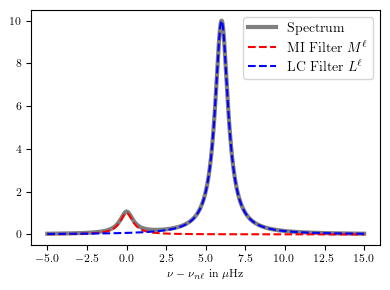

In [46]:
fontsize = 8
fig, axs = plt.subplots(figsize=(4, 3))
axs.plot(x, lor2, 'k', label='Spectrum', lw=3, alpha=0.5)
axs.plot(x, lor1, '--r', label='MI Filter $M^\\ell$')
axs.plot(x, bgtest, '--b', label='LC Filter $L^\\ell$')
axs.legend()
axs.set_xlabel('$\\nu - \\nu_{n \\ell}$ in $\\mu$Hz', fontsize=fontsize)
axs.tick_params(axis='both', labelsize=fontsize)
fig.tight_layout()
fig.savefig('/scratch/seismo/kashyap/cloud/Yandex.Disk/papers-posters-docs/2024-seismo-xl/apdx-twofilters-eg1.pdf')

In [4]:
p0 = [1., 0., 1., 0.]
lags, corr = compute_cc(lor1, lor2, maxlag=50)
lags2, corr2 = compute_cc(lor1, bgtest, maxlag=50)
_sidx = 0.6/dx

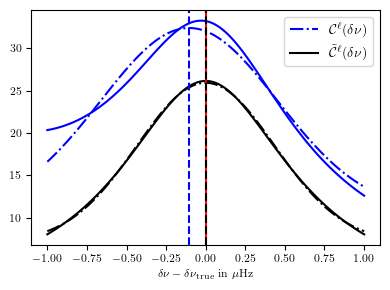

In [47]:
coeff1, var_matrix = curve_fit(gaussian, lags, corr, p0=p0)
coeff1c, var_matrix = curve_fit(gaussian, lags, corr-corr2, p0=p0)

fig, axs = plt.subplots(figsize=(4, 3))
axs.plot(lags*dx, corr, 'b')
axs.plot(lags*dx, gaussian(lags, *coeff1), '-.b', label='$\mathcal{C}^\\ell(\\delta\\nu)$')
axs.plot(lags*dx, corr-corr2, 'k', label='$\\tilde\mathcal{C}^\\ell(\\delta\\nu)$')
axs.plot(lags*dx, gaussian(lags, *coeff1c), '-.k')
axs.axvline(x=0., color='r', linestyle='solid')
axs.axvline(x=coeff1[1]*dx, color='b', linestyle='dashed')
axs.axvline(x=coeff1c[1]*dx, color='k', linestyle='dashed')
axs.legend()
axs.tick_params(axis='both', labelsize=fontsize)
axs.set_xlabel('$\\delta\\nu - \\delta\\nu_\\mathrm{true}$ in $\\mu$Hz', fontsize=fontsize)
fig.tight_layout()
fig.savefig('/scratch/seismo/kashyap/cloud/Yandex.Disk/papers-posters-docs/2024-seismo-xl/apdx-twofilters-cc.pdf')